In [2]:
%pip install wfdb

Defaulting to user installation because normal site-packages is not writeable
     ---------------------------------------- 0.0/60.8 kB ? eta -:--:--
     ---------------------------------------- 60.8/60.8 kB 3.4 MB/s eta 0:00:00
     ---------------------------------------- 0.0/76.3 kB ? eta -:--:--
     ---------------------------------------- 76.3/76.3 kB ? eta 0:00:00
  Using cached pycparser-2.22-py3-none-any.whl.metadata (943 bytes)
   ---------------------------------------- 0.0/163.8 kB ? eta -:--:--
   --------------------------------------- 163.8/163.8 kB 10.2 MB/s eta 0:00:00
   ---------------------------------------- 0.0/451.4 kB ? eta -:--:--
   ---------------------------------------- 451.4/451.4 kB ? eta 0:00:00
   ---------------------------------------- 0.0/11.1 MB ? eta -:--:--
   --------------- ------------------------ 4.4/11.1 MB 142.0 MB/s eta 0:00:01
   ---------------------------- ----------- 8.0/11.1 MB 102.9 MB/s eta 0:00:01
   -------------------------------

In [4]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import wfdb
from scipy import signal
import urllib.request
import zipfile

In [7]:
# Set random seeds for reproducibility
tf.random.set_seed(42)
np.random.seed(42)

# Configure matplotlib for better visualization
sns.set_theme()
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

# Create directories
os.makedirs('models', exist_ok=True)
os.makedirs('results/part_3', exist_ok=True)
os.makedirs('logs', exist_ok=True)
os.makedirs('data', exist_ok=True)

# Download MIT-BIH dataset
data_dir = 'data/mitdb'
if not os.path.exists(data_dir):
    print("Downloading MIT-BIH Arrhythmia Database...")
    url = "https://www.physionet.org/static/published-projects/mitdb/mit-bih-arrhythmia-database-1.0.0.zip"
    zip_path = 'data/mitdb.zip'
    
    # Download dataset
    urllib.request.urlretrieve(url, zip_path)
    
    # Extract dataset
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall('data')
    
    # Clean up
    os.remove(zip_path)
    print("Dataset downloaded and extracted successfully.")

Dataset downloaded and extracted successfully.


## 1. Data Loading and Preprocessing

Signal shape: (650000, 2)
Number of annotations: 1874
Unique beat types: ['+' 'A' 'N' 'Q' '|' '~']


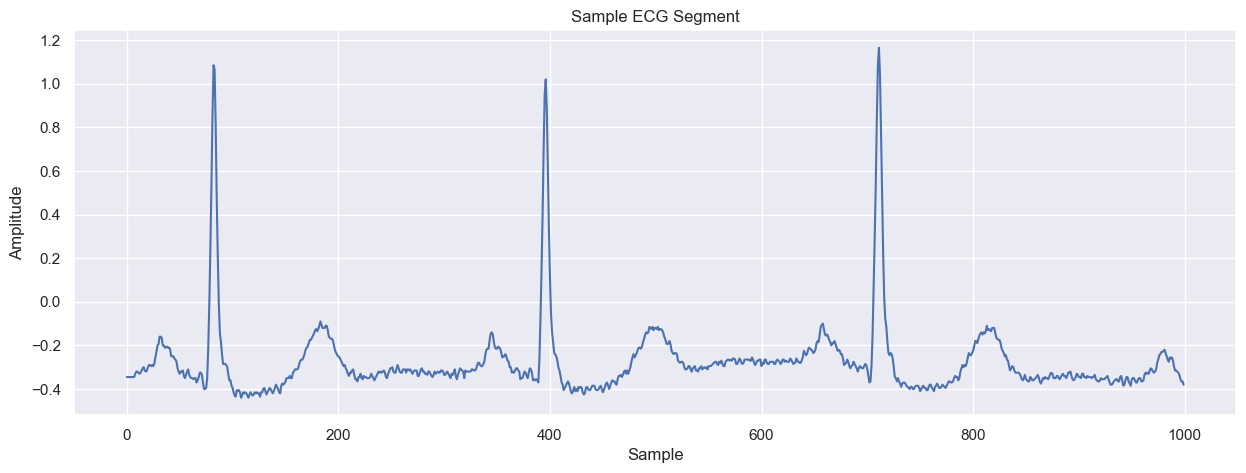

In [12]:
# Load ECG data
record_path = 'data/mit-bih-arrhythmia-database-1.0.0/101'  # Example record
record = wfdb.rdrecord(record_path)
signals = record.p_signal

# Read annotations
ann = wfdb.rdann(record_path, 'atr')
annotations = ann.symbol

# Print data information
print(f"Signal shape: {signals.shape}")
print(f"Number of annotations: {len(annotations)}")
print(f"Unique beat types: {np.unique(annotations)}")

# Plot sample ECG segment
plt.figure(figsize=(15, 5))
plt.plot(signals[:1000, 0])
plt.title('Sample ECG Segment')
plt.xlabel('Sample')
plt.ylabel('Amplitude')
plt.show()

Data shape: (1863, 180, 2)
Label distribution: [1860    3]


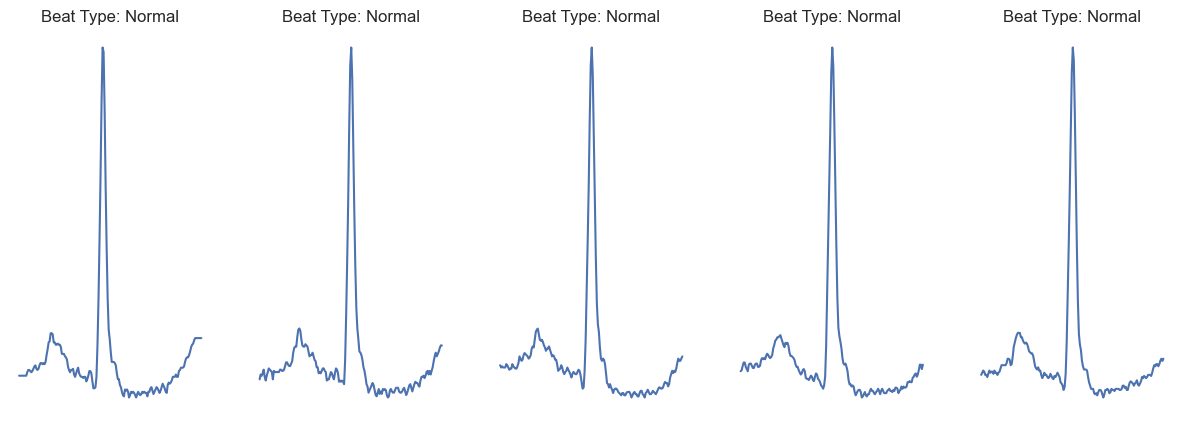

Class balance: [1860    3]


In [50]:
# Re-read annotations to avoid accidental overwrite
annotation = wfdb.rdann(record_path, 'atr')

# Preprocess ECG data
window_size = 180

# Normalize signals
signals = (signals - np.mean(signals)) / np.std(signals)

# Extract beats using correct sample positions
X = []
y = []

for pos, ann_symbol in zip(annotation.sample, annotation.symbol):
    if ann_symbol in ['N', 'L', 'R', 'A', 'V']:  # Normal and abnormal beats
        start = max(0, pos - window_size // 2)
        end = min(len(signals), pos + window_size // 2)

        segment = signals[start:end]

        # Pad if segment is too short
        if len(segment) < window_size:
            pad_len = window_size - len(segment)
            segment = np.pad(segment, ((0, pad_len), (0, 0)))

        X.append(segment)

        # Label: 0 = Normal, 1 = Abnormal
        y.append(0 if ann_symbol == 'N' else 1)

# Convert to NumPy arrays
X = np.array(X)
y = np.array(y)

print(f"Data shape: {X.shape}")
print(f"Label distribution: {np.bincount(y)}")

# Plot sample beats
plt.figure(figsize=(15, 5))
for i in range(5):
    plt.subplot(1, 5, i + 1)
    plt.plot(X[i, :, 0])
    plt.title(f'Beat Type: {"Normal" if y[i] == 0 else "Abnormal"}')
    plt.axis('off')
plt.show()

# Train/validation/test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42, stratify=y_train)

print("Class balance:", np.bincount(y))


In [54]:
def load_multiple_records(record_ids, window_size=180):
    X = []
    y = []
    
    for rid in record_ids:
        record_path = f'data/mit-bih-arrhythmia-database-1.0.0/{rid}'
        record = wfdb.rdrecord(record_path)
        signals = record.p_signal
        annotation = wfdb.rdann(record_path, 'atr')

        # Normalize
        signals = (signals - np.mean(signals)) / np.std(signals)

        for pos, ann_symbol in zip(annotation.sample, annotation.symbol):
            if ann_symbol in ['N', 'L', 'R', 'A', 'V']:
                start = max(0, pos - window_size // 2)
                end = min(len(signals), pos + window_size // 2)
                segment = signals[start:end]

                if len(segment) < window_size:
                    pad_len = window_size - len(segment)
                    segment = np.pad(segment, ((0, pad_len), (0, 0)))

                X.append(segment)
                y.append(0 if ann_symbol == 'N' else 1)
    
    return np.array(X), np.array(y)

# Use several records with known abnormal beats
record_ids = ['100', '101', '102', '103', '104', '105', '106', '107', '108']
X, y = load_multiple_records(record_ids)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, stratify=y_train, random_state=42)

print(f"Data shape: {X.shape}")
print(f"Label distribution: {np.bincount(y)}")

Data shape: (12901, 180, 2)
Label distribution: [12215   686]


## 2. Model Implementation

In [55]:
# Define model
def create_simple_nn(input_shape):
    model = tf.keras.Sequential([
        tf.keras.layers.Flatten(input_shape=input_shape),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
    )
    return model

model = create_simple_nn(input_shape=(180, 2))
model.summary()

C:\Users\cbr98\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_6 (Flatten)             │ (None, 360)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 128)            │        46,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 54,529 (213.00 KB)

 Trainable params: 54,529 (213.00 KB)

 Non-trainable params: 0 (0.00 B)

## 3. Training and Evaluation

Epoch 1/20
258/258 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9622 - auc: 0.8733 - loss: 0.1381 - val_accuracy: 0.9898 - val_auc: 0.9864 - val_loss: 0.0402 - learning_rate: 0.0010
Epoch 2/20
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9894 - auc: 0.9678 - loss: 0.0491 - val_accuracy: 0.9913 - val_auc: 0.9914 - val_loss: 0.0376 - learning_rate: 0.0010
Epoch 3/20
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9921 - auc: 0.9856 - loss: 0.0331 - val_accuracy: 0.9937 - val_auc: 0.9888 - val_loss: 0.0340 - learning_rate: 0.0010
Epoch 4/20
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9925 - auc: 0.9778 - loss: 0.0381 - val_accuracy: 0.9922 - val_auc: 0.9872 - val_loss: 0.0280 - learning_rate: 0.0010
Epoch 5/20
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9928 - auc: 0.9862 - loss: 0.0306 - val_accuracy: 0.9942 - val_auc: 0.9831 - val_loss: 0.0305 - learning_rate: 0.0010
Epoch 6/20
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9938 - auc: 0.

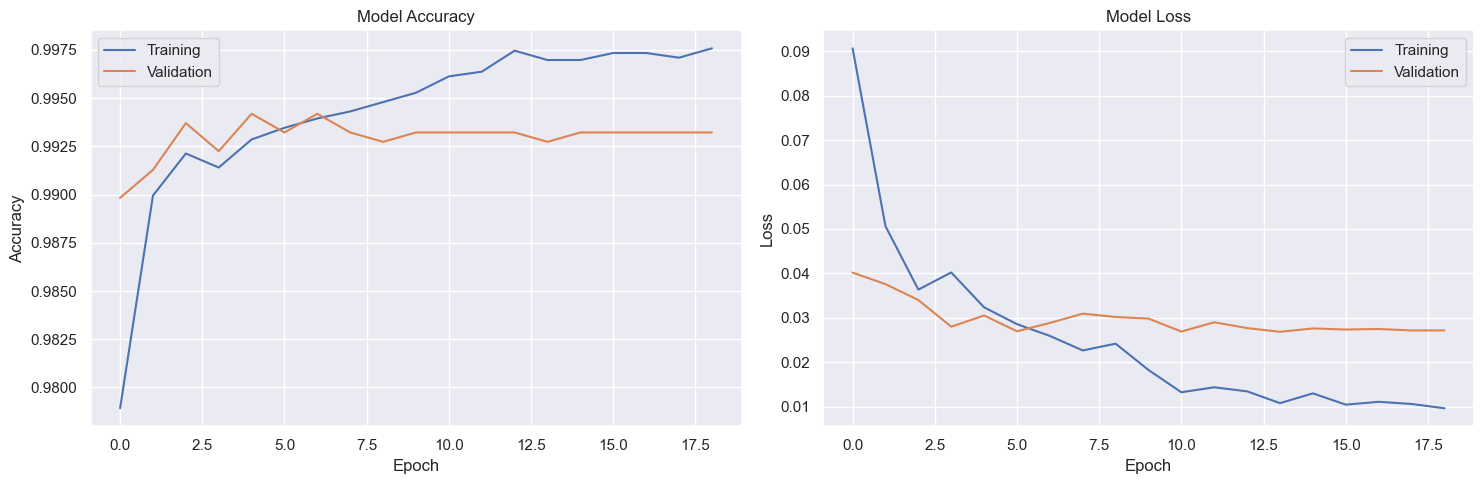

In [56]:
from sklearn.utils.class_weight import compute_class_weight

callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=3
    ),
    tf.keras.callbacks.ModelCheckpoint(
        'models/ecg_classifier.keras',
        save_best_only=True
    )
]




# Train model
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=20,
    batch_size=32,
    callbacks=callbacks,
)

# Plot training curves
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Plot accuracy
ax1.plot(history.history['accuracy'], label='Training')
ax1.plot(history.history['val_accuracy'], label='Validation')
ax1.set_title('Model Accuracy')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.legend()

# Plot loss
ax2.plot(history.history['loss'], label='Training')
ax2.plot(history.history['val_loss'], label='Validation')
ax2.set_title('Model Loss')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend()

plt.tight_layout()
plt.show()

81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 711us/step - accuracy: 0.9942 - auc: 0.9691 - loss: 0.0274   
Test accuracy: 0.9950
Test AUC: 0.9878
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step


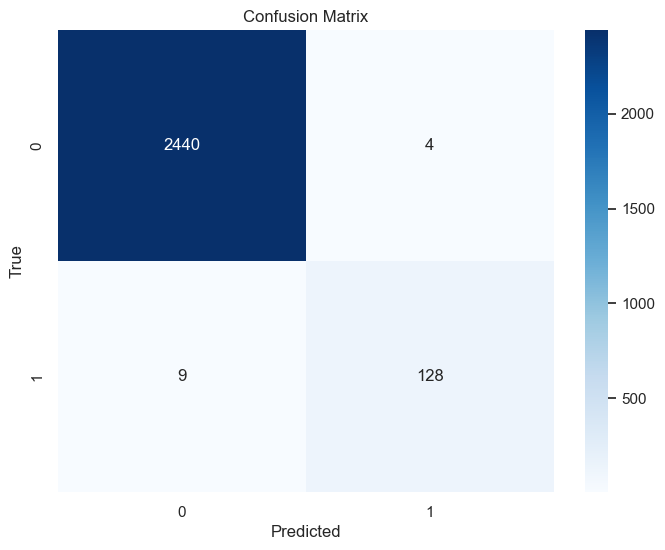

In [57]:
from sklearn.metrics import (confusion_matrix, precision_score, recall_score, f1_score)
# Evaluate model
test_loss, test_accuracy, test_auc = model.evaluate(X_test, y_test)
print(f"Test accuracy: {test_accuracy:.4f}")
print(f"Test AUC: {test_auc:.4f}")

# Get predictions
predictions = model.predict(X_test)
predicted_labels = (predictions > 0.5).astype(int).flatten()

cm = confusion_matrix(y_test, predicted_labels)
precision = precision_score(y_test, predicted_labels)
recall = recall_score(y_test, predicted_labels)
f1 = f1_score(y_test, predicted_labels)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Save metrics
metrics = {
    'model': 'ecg_classifier',
    'accuracy': float(test_accuracy),
    'auc': float(test_auc),
    'precision': float(precision),
    'recall': float(recall),
    'f1_score': float(f1),
    'confusion_matrix': cm.tolist()
}

# Save to file
with open('results/part_3/ecg_classifier_metrics.txt', 'w') as f:
    f.write(f"model: {metrics['model']}\n")
    f.write(f"accuracy: {metrics['accuracy']}\n")
    f.write(f"auc: {metrics['auc']}\n")
    f.write(f"precision: {metrics['precision']}\n")
    f.write(f"recall: {metrics['recall']}\n")
    f.write(f"f1_score: {metrics['f1_score']}\n")
    f.write(f"confusion_matrix: {metrics['confusion_matrix']}\n")
    f.write("----\n")